## DATASET

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tensorflow.keras.utils import to_categorical
import math

# Define image size
N = 28  # Resize images to (N, N)

# Define transform: Resize, Normalize, and Binarize
transform = transforms.Compose([
    transforms.Resize((N, N)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float())  # Binarization (0 or 1)
])

# Load MNIST dataset
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Extract images and labels
X_train = np.array([data[0].numpy() for data in train_data])  # Shape: (60000, 1, N, N)
Y_train = np.array([data[1] for data in train_data])           # Shape: (60000,)

X_test = np.array([data[0].numpy() for data in test_data])  # Shape: (10000, 1, N, N)
Y_test = np.array([data[1] for data in test_data])          # Shape: (10000,)

# Convert labels to one-hot encoding
Y_train_one_hot = to_categorical(Y_train, num_classes=10)
Y_test_one_hot = to_categorical(Y_test, num_classes=10)

# Define Custom Dataset
class MNISTBinaryDataset(Dataset):
    def __init__(self, images, labels):
        """
        Args:
            images: Numpy array of binary images (Shape: (None, 1, N, N))
            labels: Numpy array of one-hot encoded labels (Shape: (None, 10))
        """
        self.images = torch.tensor(images, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Create dataset instances
train_dataset = MNISTBinaryDataset(X_train, Y_train_one_hot)
test_dataset = MNISTBinaryDataset(X_test, Y_test_one_hot)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Print dataset and dataloader shapes
sample_img, sample_label = train_dataset[0]
print(f"Sample image shape: {sample_img.shape}")  # Expected: (1, N, N)
print(f"Sample label shape: {sample_label.shape}")  # Expected: (10,)

batch_imgs, batch_labels = next(iter(train_loader))
print(f"Batch image shape: {batch_imgs.shape}")  # Expected: (64, 1, N, N)
print(f"Batch label shape: {batch_labels.shape}")  # Expected: (64, 10)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 457kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.23MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Sample image shape: torch.Size([1, 28, 28])
Sample label shape: torch.Size([10])
Batch image shape: torch.Size([64, 1, 28, 28])
Batch label shape: torch.Size([64, 10])


Train


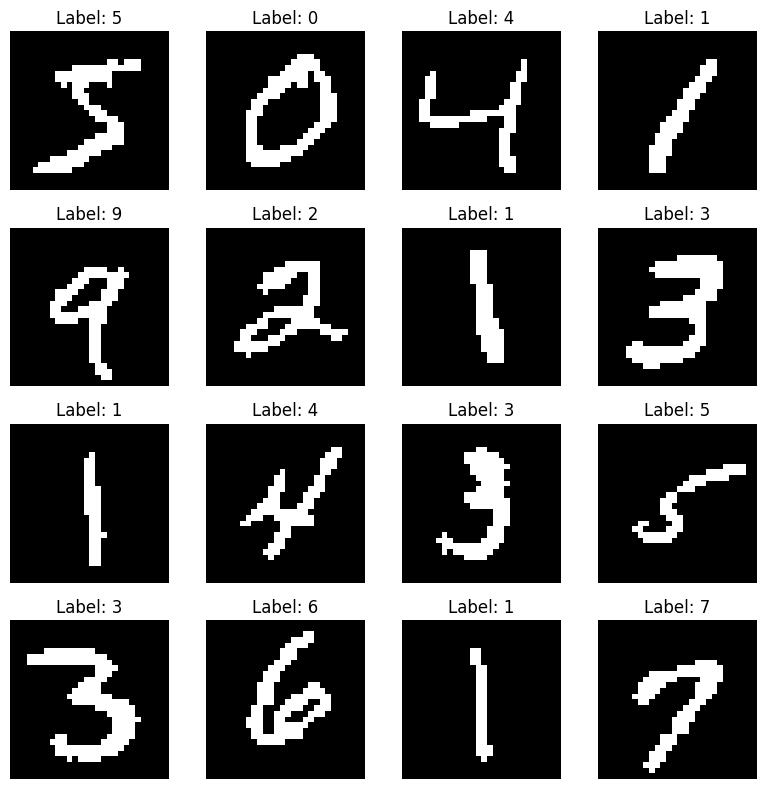

Test


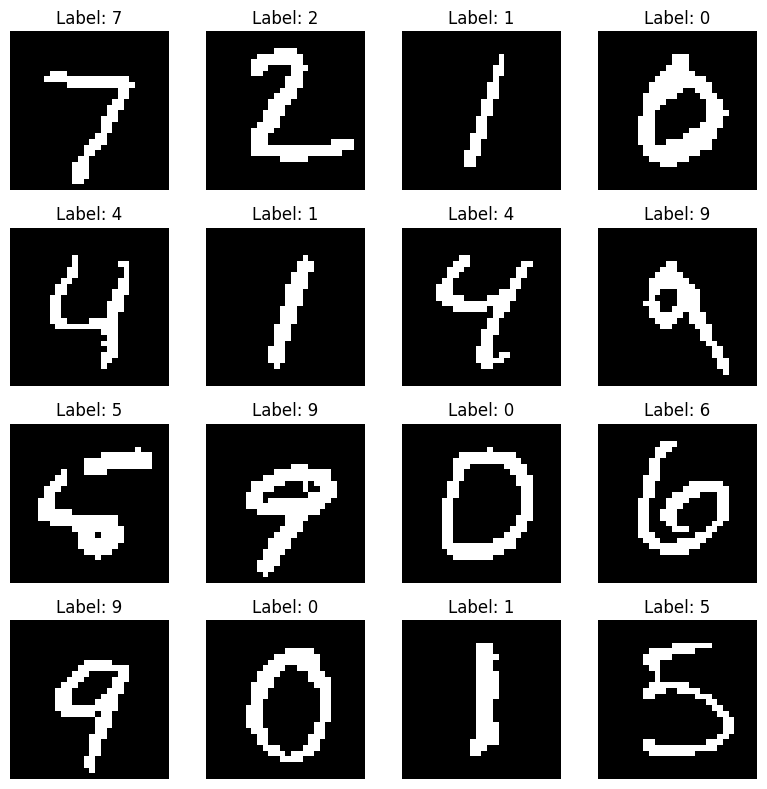

In [2]:
# Function to visualize N samples from dataset
def plot_samples(dataset, num_samples=16):
    """
    Plots a grid of sqrt(num_samples) x sqrt(num_samples) images from the dataset.

    Args:
        dataset: An instance of MNISTBinaryDataset
        num_samples: Number of images to display (should be a perfect square)
    """
    grid_size = int(math.sqrt(num_samples))
    assert grid_size**2 == num_samples, "num_samples should be a perfect square"

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))

    for i in range(num_samples):
        img, label = dataset[i]
        row, col = divmod(i, grid_size)
        axes[row, col].imshow(img.squeeze(), cmap="gray")
        axes[row, col].set_title(f"Label: {torch.argmax(label).item()}")
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()

# Plot 16 sample images
print("Train")
plot_samples(train_dataset, num_samples=16)
print("Test")
plot_samples(test_dataset, num_samples=16)


## RBM Model

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
M = 128
epochs = 15
learning_rate = 0.01
num_visible = N * N + 10  # Image pixels + one-hot encoded label
num_hidden = M  # Number of hidden units

print(device)

cuda


In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle

class RBM(nn.Module):
    def __init__(self, n_visible=784+10, n_hidden=128, device='cpu'):
        super(RBM, self).__init__()

        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.device = device

        # Initialize weights and biases
        self.W = nn.Parameter(torch.randn(n_visible, n_hidden) * 0.01)
        self.hbias = nn.Parameter(torch.zeros(n_hidden))
        self.vbias = nn.Parameter(torch.zeros(n_visible))

        self.to(self.device)

    def sample_h_given_v(self, v):
        """Sample hidden units given visible units."""
        h_mean = torch.sigmoid(F.linear(v, self.W.t(), self.hbias))
        h_sample = torch.bernoulli(h_mean)
        return h_mean, h_sample

    def sample_v_given_h(self, h):
        """Sample visible units given hidden units."""
        v_mean = torch.sigmoid(F.linear(h, self.W, self.vbias))
        v_sample = torch.bernoulli(v_mean)
        return v_mean, v_sample

    def gibbs_hvh(self, h0_sample):
        """Perform a Gibbs sampling step."""
        v_mean, v_sample = self.sample_v_given_h(h0_sample)
        h_mean, h_sample = self.sample_h_given_v(v_sample)
        return v_mean, v_sample, h_mean, h_sample

    def contrastive_divergence(self, data, k=1, lr=0.1):
        """Perform contrastive divergence training."""
        data = data.to(self.device)
        ph_mean, ph_sample = self.sample_h_given_v(data)

        chain_start = ph_sample
        for _ in range(k):
            nv_mean, nv_sample, nh_mean, nh_sample = self.gibbs_hvh(chain_start)
            chain_start = nh_sample

        self.W.data += lr * (torch.mm(data.t(), ph_sample) - torch.mm(nv_sample.t(), nh_mean)) / data.size(0)
        self.vbias.data += lr * torch.mean(data - nv_sample, dim=0)
        self.hbias.data += lr * torch.mean(ph_sample - nh_mean, dim=0)

    def energy(self, v, h):
        """Compute the RBM energy function."""
        term1 = -torch.matmul(v, torch.matmul(self.W, h))
        term2 = -torch.matmul(v, self.vbias)
        term3 = -torch.matmul(h, self.hbias)
        return term1 + term2 + term3

    def reconstruct(self, v):
        """Reconstruct visible units from hidden states."""
        v = v.to(self.device)
        h = torch.sigmoid(F.linear(v, self.W.t(), self.hbias))
        reconstructed_v = torch.sigmoid(F.linear(h, self.W, self.vbias))
        return reconstructed_v

    def save_model(self, file_path):
        """Save the trained RBM model."""
        with open(file_path, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load_model(file_path, device=None):
        """Load an RBM model."""
        with open(file_path, 'rb') as f:
            model = pickle.load(f)
        model.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(model.device)
        return model

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_rbm(train_loader, test_loader, n_visible, n_hidden, learning_rate, epochs, k, device):
    rbm = RBM(n_visible=n_visible, n_hidden=n_hidden, device = device).to(device)
    optimizer = optim.SGD([rbm.W, rbm.hbias, rbm.vbias], lr=learning_rate)

    for epoch in range(epochs):
        total_loss = 0
        for batch, label in train_loader:
            batch = batch.view(batch.size(0), -1).to(device)  # Flatten images
            batch = torch.cat((batch, label.to(device)), dim=1)  # Concatenate with labels

            optimizer.zero_grad()
            rbm.contrastive_divergence(batch, k=k)
            optimizer.step()

        # Evaluate on a test batch
        batch, label = next(iter(test_loader))
        batch = batch.view(batch.size(0), -1).to(device)
        batch = torch.cat((batch, label.to(device)), dim=1)

        with torch.no_grad():
            reconstruction = rbm.reconstruct(batch)
            loss = torch.mean((batch - reconstruction) ** 2).item()

        print(f"Epoch {epoch + 1}, k={k}: Reconstruction Loss = {loss:.4f}")

    return rbm

In [48]:
print("Training RBM with k=1")
rbm_k1 = train_rbm(train_loader, test_loader, num_visible, num_hidden, learning_rate, epochs, k=1, device= device)
rbm_k1.save_model("rbm_k1.pkl")

print("Training RBM with k=5")
rbm_k5 = train_rbm(train_loader, test_loader, num_visible, num_hidden, learning_rate, epochs, k=5, device = device)
rbm_k5.save_model("rbm_k5.pkl")

print("Training RBM with k=10")
rbm_k10 = train_rbm(train_loader, test_loader, num_visible, num_hidden, learning_rate, epochs, k=10, device = device)
rbm_k10.save_model("rbm_k10.pkl")

Training RBM with k=1
Epoch 1, k=1: Reconstruction Loss = 0.0323
Epoch 2, k=1: Reconstruction Loss = 0.0268
Epoch 3, k=1: Reconstruction Loss = 0.0250
Epoch 4, k=1: Reconstruction Loss = 0.0232
Epoch 5, k=1: Reconstruction Loss = 0.0218
Epoch 6, k=1: Reconstruction Loss = 0.0214
Epoch 7, k=1: Reconstruction Loss = 0.0205
Epoch 8, k=1: Reconstruction Loss = 0.0200
Epoch 9, k=1: Reconstruction Loss = 0.0200
Epoch 10, k=1: Reconstruction Loss = 0.0194
Epoch 11, k=1: Reconstruction Loss = 0.0192
Epoch 12, k=1: Reconstruction Loss = 0.0189
Epoch 13, k=1: Reconstruction Loss = 0.0186
Epoch 14, k=1: Reconstruction Loss = 0.0185
Epoch 15, k=1: Reconstruction Loss = 0.0182
Training RBM with k=5
Epoch 1, k=5: Reconstruction Loss = 0.0321
Epoch 2, k=5: Reconstruction Loss = 0.0267
Epoch 3, k=5: Reconstruction Loss = 0.0241
Epoch 4, k=5: Reconstruction Loss = 0.0226
Epoch 5, k=5: Reconstruction Loss = 0.0212
Epoch 6, k=5: Reconstruction Loss = 0.0205
Epoch 7, k=5: Reconstruction Loss = 0.0200
Epoc

## Load RBM

In [ ]:
rbm_k1_loaded = RBM.load_model("rbm_k1.pkl")

rbm_k5_loaded = RBM.load_model("rbm_k5.pkl")

rbm_k10_loaded = RBM.load_model("rbm_k10.pkl")

## Classification for joint

In [81]:
import torch
import torch.nn.functional as F

def classify_rbm(model, x, device="cpu"):
    """
    Classify an input image x using the trained RBM model.
    - Generate all possible one-hot encoded labels.
    - Concatenate each label with x.
    - Sample h from p(h|x, y) and compute energy.
    - Choose the label with the lowest energy.
    """
    model.to(device)  # Ensure the model is on the correct device
    x = x.flatten().to(device)  # Flatten the image and move to the correct device

    # Generate all possible one-hot labels (10 classes)
    y_classes = torch.eye(10, device=device)  # Shape: (10, 10)

    # Repeat x for each label
    x_repeated = x.repeat(10, 1)  # Shape: (10, N*N)
    xy_concat = torch.cat((x_repeated, y_classes), dim=1)  # Shape: (10, N*N + 10)

    # Sample h from p(h | x, y)
    _, h_sampled = model.sample_h_given_v(xy_concat)  # Get h samples

    # Compute energy for each (x, y, h_sampled)
    energies = torch.tensor([model.energy(v, h) for v, h in zip(xy_concat, h_sampled)], device=device)

    # Choose the label y with the lowest energy
    predicted_label = torch.argmin(energies).item()

    return predicted_label


In [82]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_rbm_classifier(model, test_loader, device="cpu"):
    """
    Evaluate the RBM-based classifier on the test dataset.
    Computes classification accuracy, confusion matrix, and other metrics.
    """
    model.to(device)  # Move model to the appropriate device
    all_preds = []
    all_targets = []

    for x, y in test_loader:
        x, y = x.to(device), y.to(device)  # Move data to device

        # Convert one-hot encoded labels to class indices
        y_true = torch.argmax(y, dim=1).cpu().numpy()

        # Predict using RBM
        y_pred = [classify_rbm(model, img, device) for img in x]

        all_preds.extend(y_pred)
        all_targets.extend(y_true)

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Compute accuracy
    accuracy = np.mean(all_preds == all_targets)
    print(f"Classification Accuracy: {accuracy * 100:.2f}%")

    # Generate confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    print(classification_report(all_targets, all_preds))


Classification Accuracy: 78.42%


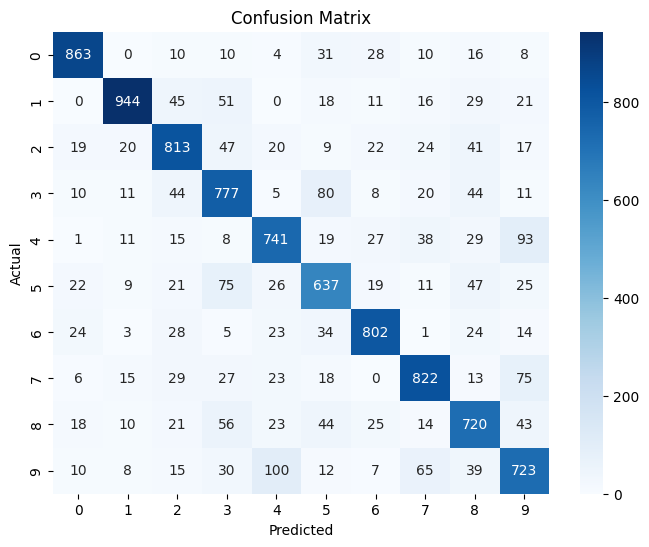

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       980
           1       0.92      0.83      0.87      1135
           2       0.78      0.79      0.78      1032
           3       0.72      0.77      0.74      1010
           4       0.77      0.75      0.76       982
           5       0.71      0.71      0.71       892
           6       0.85      0.84      0.84       958
           7       0.81      0.80      0.80      1028
           8       0.72      0.74      0.73       974
           9       0.70      0.72      0.71      1009

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.79      0.78      0.79     10000



In [84]:
evaluate_rbm_classifier(rbm_k1_loaded, test_loader, device)

Classification Accuracy: 78.62%


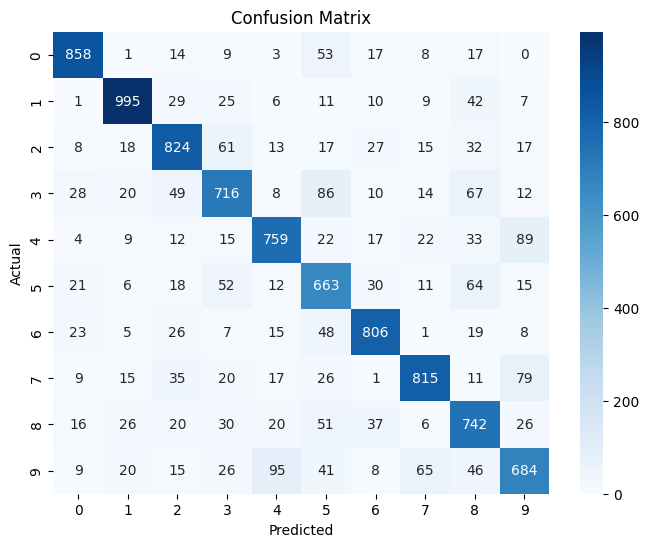

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       980
           1       0.89      0.88      0.88      1135
           2       0.79      0.80      0.79      1032
           3       0.75      0.71      0.73      1010
           4       0.80      0.77      0.79       982
           5       0.65      0.74      0.69       892
           6       0.84      0.84      0.84       958
           7       0.84      0.79      0.82      1028
           8       0.69      0.76      0.72       974
           9       0.73      0.68      0.70      1009

    accuracy                           0.79     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.79      0.79     10000



In [85]:
evaluate_rbm_classifier(rbm_k5_loaded, test_loader, device)

Classification Accuracy: 78.24%


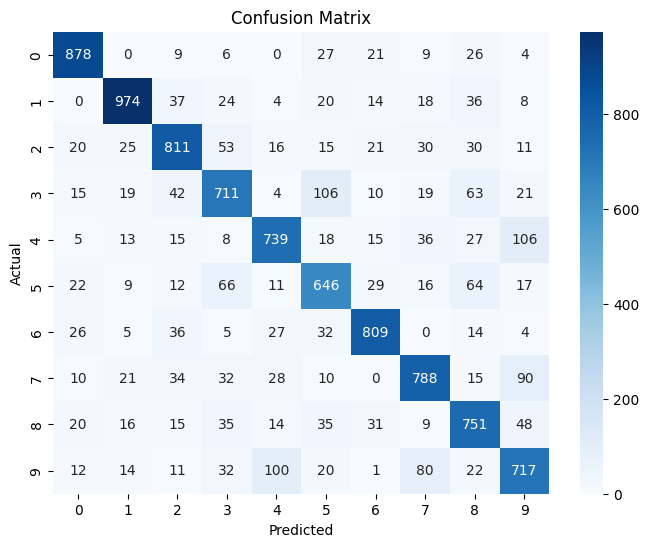

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       980
           1       0.89      0.86      0.87      1135
           2       0.79      0.79      0.79      1032
           3       0.73      0.70      0.72      1010
           4       0.78      0.75      0.77       982
           5       0.70      0.72      0.71       892
           6       0.85      0.84      0.85       958
           7       0.78      0.77      0.78      1028
           8       0.72      0.77      0.74       974
           9       0.70      0.71      0.70      1009

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



In [83]:
evaluate_rbm_classifier(rbm_k10_loaded, test_loader, device)

## DRMB

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
M = 128
epochs = 15
learning_rate = 0.01
num_visible = N * N + 10  # Image pixels + one-hot encoded label
num_hidden = M  # Number of hidden units

print(device)

cuda


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle

class DRBM(nn.Module):
    def __init__(self, n_visible=784, n_hidden=128, label_size=10, device='cpu'):
        super(DRBM, self).__init__()

        self.n_visible = n_visible  # Total input size (includes x and y)
        self.n_hidden = n_hidden
        self.label_size = label_size  # Number of label units (last 10 indices of v)
        self.feature_size = n_visible - label_size  # Feature vector x size
        self.device = device

        # Initialize weights and biases
        self.W = nn.Parameter(torch.randn(n_visible, n_hidden) * 0.01)
        self.hbias = nn.Parameter(torch.zeros(n_hidden))
        self.vbias = nn.Parameter(torch.zeros(n_visible))

        self.to(self.device)

    def sample_h_given_v(self, v):
        """Sample hidden units given visible units."""
        h_mean = torch.sigmoid(F.linear(v, self.W.t(), self.hbias))
        h_sample = torch.bernoulli(h_mean)
        return h_mean, h_sample

    def sample_v_given_h(self, h, x_fixed):
        """
        Sample visible units given hidden units but keep `x` fixed.
        Only sample `y` (last `label_size` elements of v).
        """
        v_mean = torch.sigmoid(F.linear(h, self.W, self.vbias))

        # Create a copy of v_mean but keep x_fixed unchanged
        v_sample = v_mean.clone()
        v_sample[:, :self.feature_size] = x_fixed  # Keep x unchanged
        v_sample[:, self.feature_size:] = torch.bernoulli(v_mean[:, self.feature_size:])  # Sample y

        return v_mean, v_sample

    def gibbs_hvh(self, h0_sample, x_fixed):
        """Perform a Gibbs sampling step but keep x fixed."""
        v_mean, v_sample = self.sample_v_given_h(h0_sample, x_fixed)
        h_mean, h_sample = self.sample_h_given_v(v_sample)
        return v_mean, v_sample, h_mean, h_sample

    def contrastive_divergence(self, data, k=1, lr=0.1):
        """
        Perform contrastive divergence with fixed x.
        """
        data = data.to(self.device)
        x_fixed = data[:, :self.feature_size]  # Extract x
        ph_mean, ph_sample = self.sample_h_given_v(data)

        chain_start = ph_sample
        for _ in range(k):
            nv_mean, nv_sample, nh_mean, nh_sample = self.gibbs_hvh(chain_start, x_fixed)
            chain_start = nh_sample

        # Update weights and biases
        self.W.data += lr * (torch.mm(data.t(), ph_sample) - torch.mm(nv_sample.t(), nh_mean)) / data.size(0)
        self.vbias.data += lr * torch.mean(data - nv_sample, dim=0)
        self.hbias.data += lr * torch.mean(ph_sample - nh_mean, dim=0)

    def energy(self, v, h):
        """Compute the RBM energy function."""
        term1 = -torch.sum((v @ self.W) * h, dim=1)  # Corrected
        term2 = -torch.matmul(v, self.vbias)
        term3 = -torch.matmul(h, self.hbias)
        return term1 + term2 + term3

    def reconstruct(self, v):
        """Reconstruct visible units from hidden states."""
        v = v.to(self.device)
        h = torch.sigmoid(F.linear(v, self.W.t(), self.hbias))
        reconstructed_v = torch.sigmoid(F.linear(h, self.W, self.vbias))

        # Keep x unchanged, only reconstruct y
        reconstructed_v[:, :self.feature_size] = v[:, :self.feature_size]
        return reconstructed_v , v[:, self.feature_size:]

    def save_model(self, file_path):
        """Save the trained RBM model."""
        with open(file_path, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load_model(file_path, device=None):
        """Load an RBM model."""
        with open(file_path, 'rb') as f:
            model = pickle.load(f)
        model.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(model.device)
        return model


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_drbm(train_loader, test_loader, n_visible, n_hidden, label_size, learning_rate, epochs, k, device):
    rbm = DRBM(n_visible=n_visible, n_hidden=n_hidden, label_size=label_size, device=device).to(device)
    optimizer = optim.SGD([rbm.W, rbm.hbias, rbm.vbias], lr=learning_rate)

    for epoch in range(epochs):
        total_loss = 0
        for batch, label in train_loader:
            batch = batch.view(batch.size(0), -1).to(device)  # Flatten images
            label = label.to(device)

            batch = torch.cat((batch, label), dim=1)  # Concatenate images with labels

            optimizer.zero_grad()
            rbm.contrastive_divergence(batch, k=k)
            optimizer.step()

        # Evaluate on a test batch
        batch, label = next(iter(test_loader))
        batch = batch.view(batch.size(0), -1).to(device)
        label = label.to(device)

        batch = torch.cat((batch, label), dim=1)

        with torch.no_grad():
            _,reconstruction = rbm.reconstruct(batch)
            loss = torch.mean((label - reconstruction) ** 2).item()

        print(f"Epoch {epoch + 1}, k={k}: Reconstruction Loss = {loss}")

    return rbm


In [24]:
print("Training DRBM with k=1")
drbm_k1 = train_drbm(train_loader, test_loader, num_visible, num_hidden, 10, learning_rate, epochs, k=1, device = device)
drbm_k1.save_model("drbm_k1.pkl")

print("Training DRBM with k=5")
drbm_k5 = train_drbm(train_loader, test_loader, num_visible, num_hidden, 10, learning_rate, epochs, k=5, device = device)
drbm_k5.save_model("drbm_k5.pkl")

print("Training DRBM with k=10")
drbm_k10 = train_drbm(train_loader, test_loader, num_visible, num_hidden, 10, learning_rate, epochs, k=10, device = device)
drbm_k10.save_model("drbm_k10.pkl")

Training DRBM with k=1
Epoch 1, k=1: Reconstruction Loss = 0.0
Epoch 2, k=1: Reconstruction Loss = 0.0
Epoch 3, k=1: Reconstruction Loss = 0.0
Epoch 4, k=1: Reconstruction Loss = 0.0
Epoch 5, k=1: Reconstruction Loss = 0.0
Epoch 6, k=1: Reconstruction Loss = 0.0
Epoch 7, k=1: Reconstruction Loss = 0.0
Epoch 8, k=1: Reconstruction Loss = 0.0
Epoch 9, k=1: Reconstruction Loss = 0.0
Epoch 10, k=1: Reconstruction Loss = 0.0
Epoch 11, k=1: Reconstruction Loss = 0.0
Epoch 12, k=1: Reconstruction Loss = 0.0
Epoch 13, k=1: Reconstruction Loss = 0.0
Epoch 14, k=1: Reconstruction Loss = 0.0
Epoch 15, k=1: Reconstruction Loss = 0.0
Training DRBM with k=5
Epoch 1, k=5: Reconstruction Loss = 0.0
Epoch 2, k=5: Reconstruction Loss = 0.0
Epoch 3, k=5: Reconstruction Loss = 0.0
Epoch 4, k=5: Reconstruction Loss = 0.0
Epoch 5, k=5: Reconstruction Loss = 0.0
Epoch 6, k=5: Reconstruction Loss = 0.0
Epoch 7, k=5: Reconstruction Loss = 0.0
Epoch 8, k=5: Reconstruction Loss = 0.0
Epoch 9, k=5: Reconstruction

## LOAD DRBM

In [38]:
drbm_k1_loaded = DRBM.load_model("drbm_k1.pkl")
drbm_k5_loaded = DRBM.load_model("drbm_k5.pkl")
drbm_k10_loaded = DRBM.load_model("drbm_k10.pkl")

## Clasification for Conditonal

In [42]:
import torch
import torch.nn.functional as F

def classify_drbm(model, x, device="cpu"):
    """
    Classify an input image x using the trained RBM model.
    - Generate all possible one-hot encoded labels.
    - Concatenate each label with x.
    - Sample h from p(h|x, y) and compute energy.
    - Choose the label with the lowest energy.
    """
    model.to(device)
    x = x.flatten().to(device)

    # Generate all possible one-hot labels (10 classes)
    y_classes = torch.eye(model.label_size, device=device)

    # Concatenate each label with x
    xy_concat = torch.cat((x.expand(model.label_size, -1), y_classes), dim=1)


    # Sample hidden states
    _, h_sampled = model.sample_h_given_v(xy_concat)

    # Compute energies
    energies = model.energy(xy_concat, h_sampled).detach()

    # Return the label with the lowest energy
    return torch.argmin(energies).item()


In [43]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_drbm_classifier(model, test_loader, device="cpu"):
    """
    Evaluate the RBM-based classifier on the test dataset.
    Computes accuracy, confusion matrix, and classification report.
    """
    model.to(device)
    all_preds, all_targets = [], []

    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_true = y.argmax(dim=1).cpu().numpy()

        # Batch processing for efficiency
        y_pred = [classify_drbm(model, img, device) for img in x]

        all_preds.extend(y_pred)
        all_targets.extend(y_true)

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Compute accuracy
    accuracy = np.mean(all_preds == all_targets)
    print(f"Classification Accuracy: {accuracy * 100:.2f}%")

    # Generate and plot confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(model.label_size), yticklabels=range(model.label_size))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    print(classification_report(all_targets, all_preds, digits=4))


Classification Accuracy: 80.53%


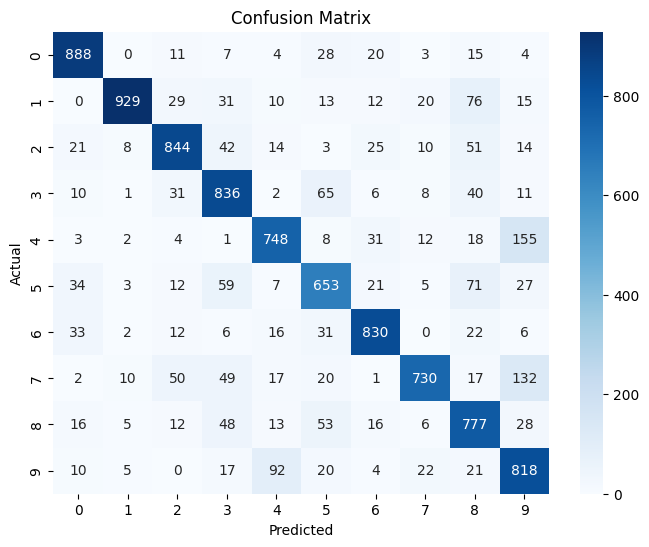

              precision    recall  f1-score   support

           0     0.8732    0.9061    0.8893       980
           1     0.9627    0.8185    0.8848      1135
           2     0.8398    0.8178    0.8287      1032
           3     0.7628    0.8277    0.7939      1010
           4     0.8104    0.7617    0.7853       982
           5     0.7304    0.7321    0.7312       892
           6     0.8592    0.8664    0.8628       958
           7     0.8946    0.7101    0.7918      1028
           8     0.7013    0.7977    0.7464       974
           9     0.6760    0.8107    0.7373      1009

    accuracy                         0.8053     10000
   macro avg     0.8110    0.8049    0.8051     10000
weighted avg     0.8141    0.8053    0.8068     10000



In [44]:
evaluate_drbm_classifier(drbm_k1_loaded, test_loader, device)

Classification Accuracy: 81.97%


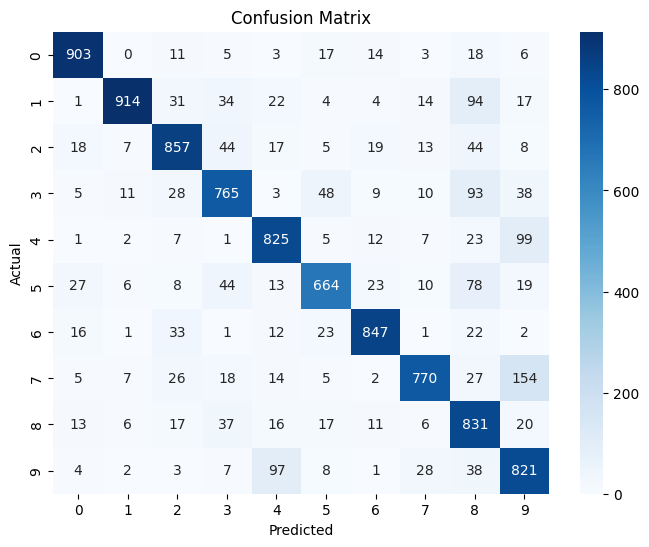

              precision    recall  f1-score   support

           0     0.9094    0.9214    0.9154       980
           1     0.9561    0.8053    0.8742      1135
           2     0.8394    0.8304    0.8349      1032
           3     0.8002    0.7574    0.7782      1010
           4     0.8072    0.8401    0.8234       982
           5     0.8342    0.7444    0.7867       892
           6     0.8992    0.8841    0.8916       958
           7     0.8933    0.7490    0.8148      1028
           8     0.6554    0.8532    0.7413       974
           9     0.6934    0.8137    0.7487      1009

    accuracy                         0.8197     10000
   macro avg     0.8288    0.8199    0.8209     10000
weighted avg     0.8305    0.8197    0.8216     10000



In [45]:
evaluate_drbm_classifier(drbm_k5_loaded, test_loader, device)

Classification Accuracy: 82.57%


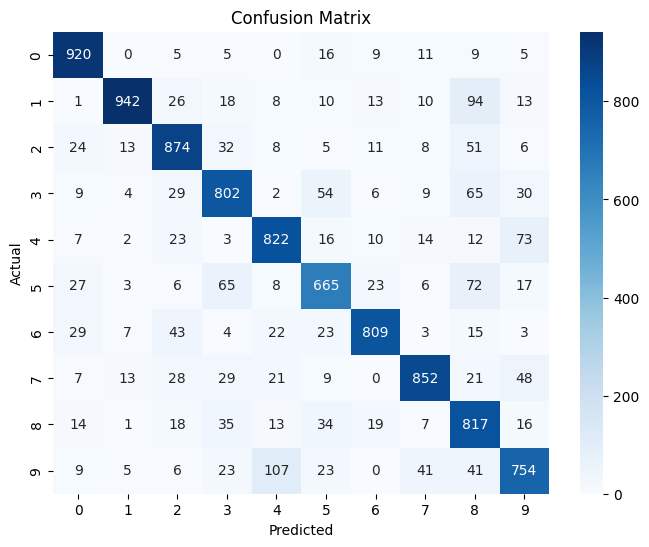

              precision    recall  f1-score   support

           0     0.8787    0.9388    0.9077       980
           1     0.9515    0.8300    0.8866      1135
           2     0.8261    0.8469    0.8364      1032
           3     0.7894    0.7941    0.7917      1010
           4     0.8131    0.8371    0.8249       982
           5     0.7778    0.7455    0.7613       892
           6     0.8989    0.8445    0.8708       958
           7     0.8866    0.8288    0.8567      1028
           8     0.6825    0.8388    0.7526       974
           9     0.7813    0.7473    0.7639      1009

    accuracy                         0.8257     10000
   macro avg     0.8286    0.8252    0.8253     10000
weighted avg     0.8309    0.8257    0.8267     10000



In [46]:
evaluate_drbm_classifier(drbm_k10_loaded, test_loader, device)

## Joint and Conditional mixed

In [93]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
M = 128
epochs = 15
learning_rate = 0.01
num_visible = N * N + 10  # Image pixels + one-hot encoded label
num_hidden = M  # Number of hidden units

print(device)

cuda


In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle

class UnifiedRBM(nn.Module):
    def __init__(self, n_visible=784+10, n_hidden=128, label_size=10, alpha=0.5, device='cpu'):
        super(UnifiedRBM, self).__init__()

        self.n_visible = n_visible # Total input size
        self.n_hidden = n_hidden
        self.label_size = label_size
        self.feature_size = n_visible - label_size  # Features without labels
        self.alpha = alpha  # Loss weight factor
        self.device = device

        # Initialize weights and biases
        self.W = nn.Parameter(torch.randn(self.n_visible, n_hidden) * 0.01)
        self.hbias = nn.Parameter(torch.zeros(n_hidden))
        self.vbias = nn.Parameter(torch.zeros(self.n_visible))

        self.to(self.device)

    def sample_h_given_v(self, v):
        """Sample hidden units given visible units."""
        h_mean = torch.sigmoid(F.linear(v, self.W.t(), self.hbias))
        h_sample = torch.bernoulli(h_mean)
        return h_mean, h_sample

    def sample_v_given_h(self, h, x_fixed=None):
        """Sample visible units given hidden units. If x_fixed is given, only sample y."""
        v_mean = torch.sigmoid(F.linear(h, self.W, self.vbias))
        v_sample = torch.bernoulli(v_mean)

        if x_fixed is not None:
            v_sample[:, :self.feature_size] = x_fixed  # Keep x unchanged, only sample y
        return v_mean, v_sample

    def gibbs_hvh(self, h0_sample, x_fixed=None):
        """Perform a Gibbs sampling step, optionally keeping x fixed."""
        v_mean, v_sample = self.sample_v_given_h(h0_sample, x_fixed)
        h_mean, h_sample = self.sample_h_given_v(v_sample)
        return v_mean, v_sample, h_mean, h_sample

    def contrastive_divergence(self, data, k=1, lr=0.1):
        """
        Perform contrastive divergence training with merged updates.
        """
        data = data.to(self.device)
        x_fixed = data[:, :self.feature_size]  # Extract x for discrimination

        # Step 1: Dis Loss Computation
        ph_mean_dis, ph_sample_dis = self.sample_h_given_v(data)

        chain_start_dis = ph_sample_dis
        for _ in range(k):
            nv_mean_dis, nv_sample_dis, nh_mean_dis, nh_sample_dis = self.gibbs_hvh(chain_start_dis, x_fixed)
            chain_start_dis = nh_sample_dis

        # Compute Dis updates
        W_update_dis = torch.mm(data.t(), ph_sample_dis) - torch.mm(nv_sample_dis.t(), nh_mean_dis)
        vbias_update_dis = torch.mean(data - nv_sample_dis, dim=0)
        hbias_update_dis = torch.mean(ph_sample_dis - nh_mean_dis, dim=0)

        # Step 2: Gen Loss Computation
        ph_mean_gen, ph_sample_gen = self.sample_h_given_v(data)

        chain_start_gen = ph_sample_gen
        for _ in range(k):
            nv_mean_gen, nv_sample_gen, nh_mean_gen, nh_sample_gen = self.gibbs_hvh(chain_start_gen)
            chain_start_gen = nh_sample_gen

        # Compute Gen updates
        W_update_gen = torch.mm(data.t(), ph_sample_gen) - torch.mm(nv_sample_gen.t(), nh_mean_gen)
        vbias_update_gen = torch.mean(data - nv_sample_gen, dim=0)
        hbias_update_gen = torch.mean(ph_sample_gen - nh_mean_gen, dim=0)

        # Step 3: Merge Updates with Alpha and Apply
        W_update = W_update_dis + (self.alpha) * W_update_gen
        vbias_update = vbias_update_dis + (self.alpha) * vbias_update_gen
        hbias_update = hbias_update_dis + (self.alpha) * hbias_update_gen

        # Apply updates
        self.W.data += lr * W_update / data.size(0)
        self.vbias.data += lr * vbias_update
        self.hbias.data += lr * hbias_update

    def energy(self, v, h):
        """Compute the RBM energy function."""
        term1 = -torch.matmul(v, torch.matmul(self.W, h))
        term2 = -torch.matmul(v, self.vbias)
        term3 = -torch.matmul(h, self.hbias)
        return term1 + term2 + term3

    def reconstruct(self, v):
        """Reconstruct visible units from hidden states."""
        v = v.to(self.device)
        h = torch.sigmoid(F.linear(v, self.W.t(), self.hbias))
        reconstructed_v = torch.sigmoid(F.linear(h, self.W, self.vbias))
        # reconstructed_v[:, :self.feature_size] = v[:, :self.feature_size]  # Keep x unchanged
        return reconstructed_v, v[:, self.feature_size:]

    def save_model(self, file_path):
        """Save the trained RBM model."""
        with open(file_path, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load_model(file_path, device=None):
        """Load an RBM model."""
        with open(file_path, 'rb') as f:
            model = pickle.load(f)
        model.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(model.device)
        return model


In [95]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_UnifiedRBM(train_loader, test_loader, n_visible, n_hidden, label_size, learning_rate, epochs, k, alpha,device):
    rbm = UnifiedRBM(n_visible=n_visible, n_hidden=n_hidden, label_size=label_size, alpha = alpha, device=device).to(device)
    optimizer = optim.SGD([rbm.W, rbm.hbias, rbm.vbias], lr=learning_rate)

    for epoch in range(epochs):
        total_loss = 0
        for batch, label in train_loader:
            batch = batch.view(batch.size(0), -1).to(device)  # Flatten images
            label = label.to(device)

            batch = torch.cat((batch, label), dim=1)  # Concatenate images with labels

            optimizer.zero_grad()
            rbm.contrastive_divergence(batch, k=k)
            optimizer.step()

        # Evaluate on a test batch
        batch, label = next(iter(test_loader))
        batch = batch.view(batch.size(0), -1).to(device)
        label = label.to(device)

        batch = torch.cat((batch, label), dim=1)

        with torch.no_grad():
            reconstruction,_ = rbm.reconstruct(batch)
            loss = torch.mean((batch - reconstruction) ** 2).item()

        print(f"Epoch {epoch + 1}, k={k}: Reconstruction Loss = {loss}")

    return rbm

In [96]:
print("Training DRBM with k=1")
urbm_k1_001 = train_UnifiedRBM(train_loader, test_loader, num_visible, num_hidden, 10, learning_rate, epochs, k=1, alpha = 0.01 ,device = device)
urbm_k1_001.save_model("urbm_k1_001.pkl")

print("Training DRBM with k=5")
urbm_k5_001 = train_UnifiedRBM(train_loader, test_loader, num_visible, num_hidden, 10, learning_rate, epochs, k=5, alpha = 0.01 ,device = device)
urbm_k5_001.save_model("urbm_k5_001.pkl")

print("Training DRBM with k=10")
urbm_k10_001 = train_UnifiedRBM(train_loader, test_loader, num_visible, num_hidden, 10, learning_rate, epochs, k=10, alpha = 0.01 ,device = device)
urbm_k10_001.save_model("urbm_k10_001.pkl")

Training DRBM with k=1
Epoch 1, k=1: Reconstruction Loss = 0.07218830287456512
Epoch 2, k=1: Reconstruction Loss = 0.06159641221165657
Epoch 3, k=1: Reconstruction Loss = 0.055952560156583786
Epoch 4, k=1: Reconstruction Loss = 0.052706170827150345
Epoch 5, k=1: Reconstruction Loss = 0.050345778465270996
Epoch 6, k=1: Reconstruction Loss = 0.04973601922392845
Epoch 7, k=1: Reconstruction Loss = 0.04792751744389534
Epoch 8, k=1: Reconstruction Loss = 0.04678073525428772
Epoch 9, k=1: Reconstruction Loss = 0.04551159590482712
Epoch 10, k=1: Reconstruction Loss = 0.04403494670987129
Epoch 11, k=1: Reconstruction Loss = 0.043978508561849594
Epoch 12, k=1: Reconstruction Loss = 0.044350650161504745
Epoch 13, k=1: Reconstruction Loss = 0.043073974549770355
Epoch 14, k=1: Reconstruction Loss = 0.04285130649805069
Epoch 15, k=1: Reconstruction Loss = 0.042962972074747086
Training DRBM with k=5
Epoch 1, k=5: Reconstruction Loss = 0.07884445041418076
Epoch 2, k=5: Reconstruction Loss = 0.0609658

In [97]:
print("Training DRBM with k=1")
urbm_k1_01 = train_UnifiedRBM(train_loader, test_loader, num_visible, num_hidden, 10, learning_rate, epochs, k=1, alpha = 0.1 ,device = device)
urbm_k1_01.save_model("urbm_k1_01.pkl")

print("Training DRBM with k=5")
urbm_k5_01 = train_UnifiedRBM(train_loader, test_loader, num_visible, num_hidden, 10, learning_rate, epochs, k=5, alpha = 0.1 ,device = device)
urbm_k5_01.save_model("urbm_k5_01.pkl")

print("Training DRBM with k=10")
urbm_k10_01 = train_UnifiedRBM(train_loader, test_loader, num_visible, num_hidden, 10, learning_rate, epochs, k=10, alpha = 0.1 ,device = device)
urbm_k10_01.save_model("urbm_k10_01.pkl")

Training DRBM with k=1
Epoch 1, k=1: Reconstruction Loss = 0.048633377999067307
Epoch 2, k=1: Reconstruction Loss = 0.041804563254117966
Epoch 3, k=1: Reconstruction Loss = 0.03809165209531784
Epoch 4, k=1: Reconstruction Loss = 0.03609125316143036
Epoch 5, k=1: Reconstruction Loss = 0.034739766269922256
Epoch 6, k=1: Reconstruction Loss = 0.033370476216077805
Epoch 7, k=1: Reconstruction Loss = 0.031932536512613297
Epoch 8, k=1: Reconstruction Loss = 0.03149319812655449
Epoch 9, k=1: Reconstruction Loss = 0.03039051964879036
Epoch 10, k=1: Reconstruction Loss = 0.02989770472049713
Epoch 11, k=1: Reconstruction Loss = 0.029491713270545006
Epoch 12, k=1: Reconstruction Loss = 0.02887231856584549
Epoch 13, k=1: Reconstruction Loss = 0.028346596285700798
Epoch 14, k=1: Reconstruction Loss = 0.028209565207362175
Epoch 15, k=1: Reconstruction Loss = 0.02769337221980095
Training DRBM with k=5
Epoch 1, k=5: Reconstruction Loss = 0.0478309690952301
Epoch 2, k=5: Reconstruction Loss = 0.0408513

In [98]:
print("Training DRBM with k=1")
urbm_k1_1 = train_UnifiedRBM(train_loader, test_loader, num_visible, num_hidden, 10, learning_rate, epochs, k=1, alpha = 1 ,device = device)
urbm_k1_1.save_model("urbm_k1_1.pkl")

print("Training DRBM with k=5")
urbm_k5_1 = train_UnifiedRBM(train_loader, test_loader, num_visible, num_hidden, 10, learning_rate, epochs, k=5, alpha = 1 ,device = device)
urbm_k5_1.save_model("urbm_k5_1.pkl")

print("Training DRBM with k=10")
urbm_k10_1 = train_UnifiedRBM(train_loader, test_loader, num_visible, num_hidden, 10, learning_rate, epochs, k=10, alpha = 1 ,device = device)
urbm_k10_1.save_model("urbm_k10_1.pkl")

Training DRBM with k=1
Epoch 1, k=1: Reconstruction Loss = 0.031306296586990356
Epoch 2, k=1: Reconstruction Loss = 0.02698265202343464
Epoch 3, k=1: Reconstruction Loss = 0.024737892672419548
Epoch 4, k=1: Reconstruction Loss = 0.023726284503936768
Epoch 5, k=1: Reconstruction Loss = 0.022488519549369812
Epoch 6, k=1: Reconstruction Loss = 0.021467827260494232
Epoch 7, k=1: Reconstruction Loss = 0.020969441160559654
Epoch 8, k=1: Reconstruction Loss = 0.020514219999313354
Epoch 9, k=1: Reconstruction Loss = 0.02009253017604351
Epoch 10, k=1: Reconstruction Loss = 0.01989528350532055
Epoch 11, k=1: Reconstruction Loss = 0.019414592534303665
Epoch 12, k=1: Reconstruction Loss = 0.019188832491636276
Epoch 13, k=1: Reconstruction Loss = 0.018776657059788704
Epoch 14, k=1: Reconstruction Loss = 0.018955446779727936
Epoch 15, k=1: Reconstruction Loss = 0.018631791695952415
Training DRBM with k=5
Epoch 1, k=5: Reconstruction Loss = 0.03181348741054535
Epoch 2, k=5: Reconstruction Loss = 0.02

## Load UnifiedRBM

In [99]:
urbm_k1_loaded_001 = DRBM.load_model("urbm_k1_001.pkl")
urbm_k5_loaded_001 = DRBM.load_model("urbm_k5_001.pkl")
urbm_k10_loaded_001 = DRBM.load_model("urbm_k10_001.pkl")

In [100]:
urbm_k1_loaded_01 = DRBM.load_model("urbm_k1_01.pkl")
urbm_k5_loaded_01 = DRBM.load_model("urbm_k5_01.pkl")
urbm_k10_loaded_01 = DRBM.load_model("urbm_k10_01.pkl")

In [101]:
urbm_k1_loaded_1 = DRBM.load_model("urbm_k1_1.pkl")
urbm_k5_loaded_1 = DRBM.load_model("urbm_k5_1.pkl")
urbm_k10_loaded_1 = DRBM.load_model("urbm_k10_1.pkl")

## Classification for UnifiedRBM

In [102]:
import torch
import torch.nn.functional as F

def classify_urbm(model, x, device="cpu"):
    """
    Classify an input image x using the trained RBM model.
    - Generate all possible one-hot encoded labels.
    - Concatenate each label with x.
    - Sample h from p(h|x, y) and compute energy.
    - Choose the label with the lowest energy.
    """
    model.to(device)  # Ensure the model is on the correct device
    x = x.flatten().to(device)  # Flatten the image and move to the correct device

    # Generate all possible one-hot labels (10 classes)
    y_classes = torch.eye(10, device=device)  # Shape: (10, 10)

    # Repeat x for each label
    x_repeated = x.repeat(10, 1)  # Shape: (10, N*N)
    xy_concat = torch.cat((x_repeated, y_classes), dim=1)  # Shape: (10, N*N + 10)

    # Sample h from p(h | x, y)
    _, h_sampled = model.sample_h_given_v(xy_concat)  # Get h samples

    # Compute energy for each (x, y, h_sampled)
    energies = torch.tensor([model.energy(v, h) for v, h in zip(xy_concat, h_sampled)], device=device)

    # Choose the label y with the lowest energy
    predicted_label = torch.argmin(energies).item()

    return predicted_label


In [103]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_urbm_classifier(model, test_loader, device="cpu"):
    """
    Evaluate the RBM-based classifier on the test dataset.
    Computes classification accuracy, confusion matrix, and other metrics.
    """
    model.to(device)  # Move model to the appropriate device
    all_preds = []
    all_targets = []

    for x, y in test_loader:
        x, y = x.to(device), y.to(device)  # Move data to device

        # Convert one-hot encoded labels to class indices
        y_true = torch.argmax(y, dim=1).cpu().numpy()

        # Predict using RBM
        y_pred = [classify_urbm(model, img, device) for img in x]

        all_preds.extend(y_pred)
        all_targets.extend(y_true)

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Compute accuracy
    accuracy = np.mean(all_preds == all_targets)
    print(f"Classification Accuracy: {accuracy * 100:.2f}%")

    # Generate confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    print(classification_report(all_targets, all_preds))


Classification Accuracy: 76.30%


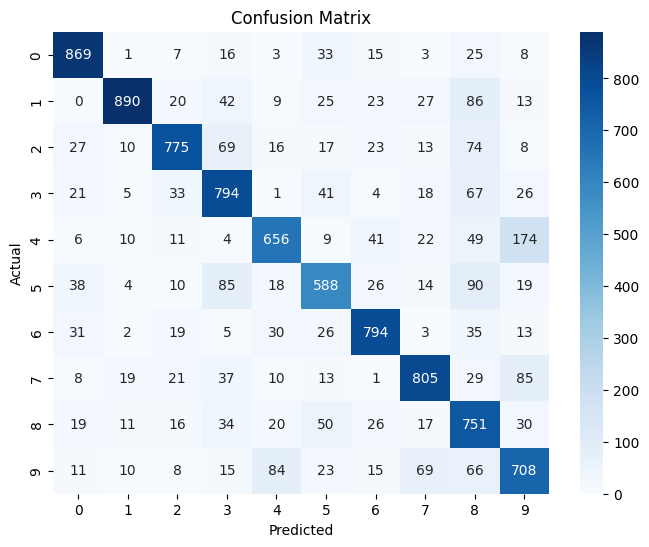

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       980
           1       0.93      0.78      0.85      1135
           2       0.84      0.75      0.79      1032
           3       0.72      0.79      0.75      1010
           4       0.77      0.67      0.72       982
           5       0.71      0.66      0.68       892
           6       0.82      0.83      0.82       958
           7       0.81      0.78      0.80      1028
           8       0.59      0.77      0.67       974
           9       0.65      0.70      0.68      1009

    accuracy                           0.76     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.77      0.76      0.76     10000



In [104]:
evaluate_urbm_classifier(urbm_k1_loaded_001, test_loader, device)

Classification Accuracy: 79.87%


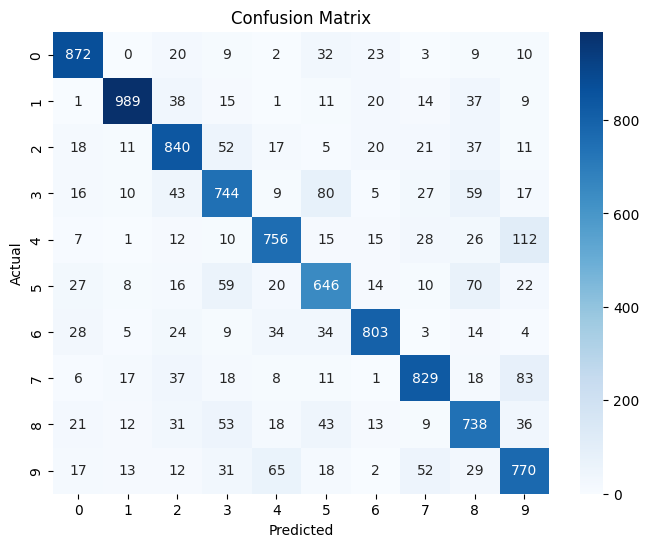

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       980
           1       0.93      0.87      0.90      1135
           2       0.78      0.81      0.80      1032
           3       0.74      0.74      0.74      1010
           4       0.81      0.77      0.79       982
           5       0.72      0.72      0.72       892
           6       0.88      0.84      0.86       958
           7       0.83      0.81      0.82      1028
           8       0.71      0.76      0.73       974
           9       0.72      0.76      0.74      1009

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



In [105]:
evaluate_urbm_classifier(urbm_k1_loaded_01, test_loader, device)

Classification Accuracy: 82.30%


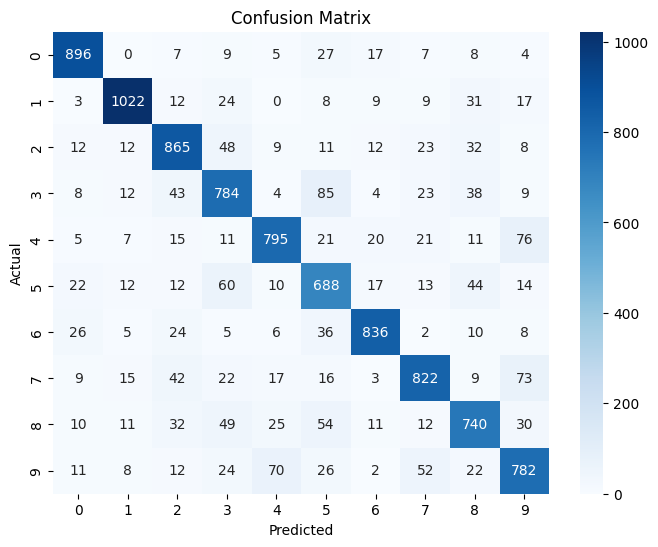

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       980
           1       0.93      0.90      0.91      1135
           2       0.81      0.84      0.83      1032
           3       0.76      0.78      0.77      1010
           4       0.84      0.81      0.83       982
           5       0.71      0.77      0.74       892
           6       0.90      0.87      0.89       958
           7       0.84      0.80      0.82      1028
           8       0.78      0.76      0.77       974
           9       0.77      0.78      0.77      1009

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



In [106]:
evaluate_urbm_classifier(urbm_k1_loaded_1, test_loader, device)

Classification Accuracy: 79.50%


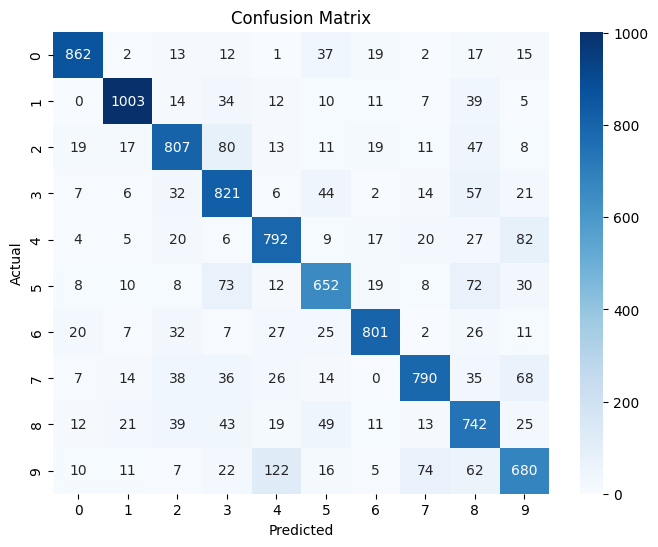

              precision    recall  f1-score   support

           0       0.91      0.88      0.89       980
           1       0.92      0.88      0.90      1135
           2       0.80      0.78      0.79      1032
           3       0.72      0.81      0.77      1010
           4       0.77      0.81      0.79       982
           5       0.75      0.73      0.74       892
           6       0.89      0.84      0.86       958
           7       0.84      0.77      0.80      1028
           8       0.66      0.76      0.71       974
           9       0.72      0.67      0.70      1009

    accuracy                           0.80     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.80      0.80     10000



In [107]:
evaluate_urbm_classifier(urbm_k5_loaded_001, test_loader, device)

Classification Accuracy: 80.80%


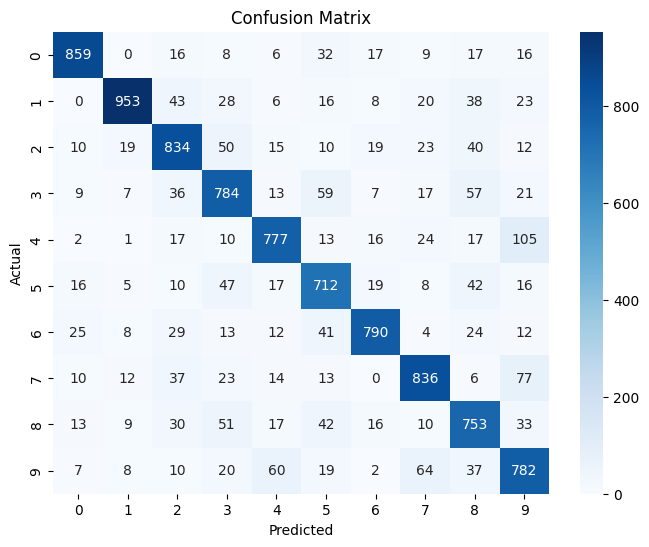

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       980
           1       0.93      0.84      0.88      1135
           2       0.79      0.81      0.80      1032
           3       0.76      0.78      0.77      1010
           4       0.83      0.79      0.81       982
           5       0.74      0.80      0.77       892
           6       0.88      0.82      0.85       958
           7       0.82      0.81      0.82      1028
           8       0.73      0.77      0.75       974
           9       0.71      0.78      0.74      1009

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



In [108]:
evaluate_urbm_classifier(urbm_k5_loaded_01, test_loader, device)

Classification Accuracy: 82.03%


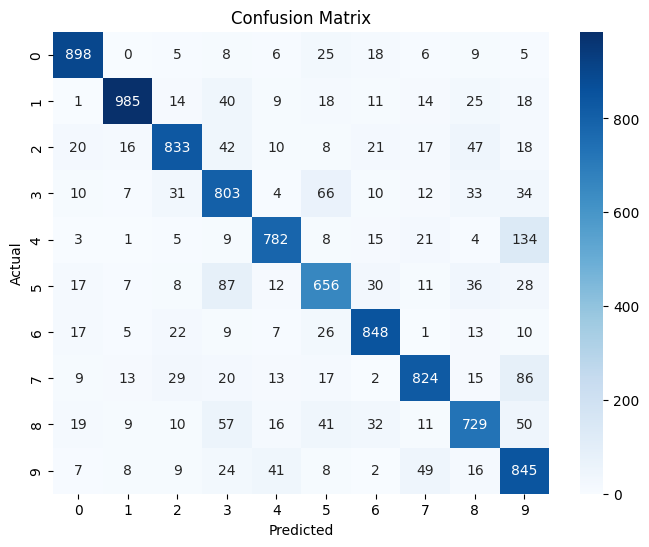

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       980
           1       0.94      0.87      0.90      1135
           2       0.86      0.81      0.83      1032
           3       0.73      0.80      0.76      1010
           4       0.87      0.80      0.83       982
           5       0.75      0.74      0.74       892
           6       0.86      0.89      0.87       958
           7       0.85      0.80      0.83      1028
           8       0.79      0.75      0.77       974
           9       0.69      0.84      0.76      1009

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



In [109]:
evaluate_urbm_classifier(urbm_k5_loaded_1, test_loader, device)

Classification Accuracy: 80.90%


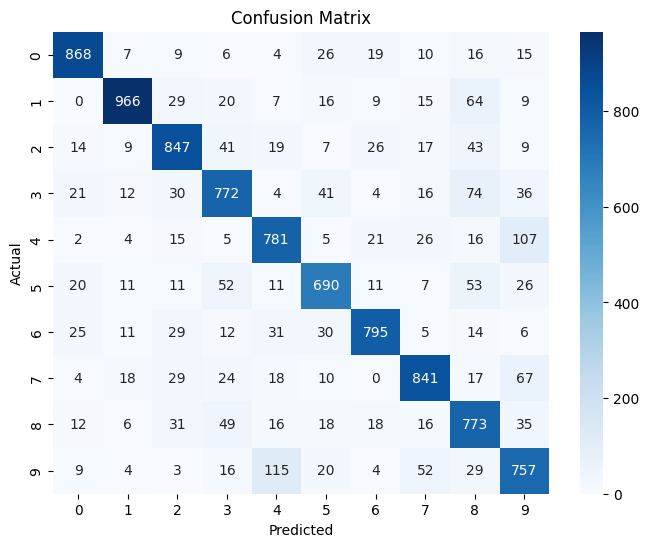

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       980
           1       0.92      0.85      0.89      1135
           2       0.82      0.82      0.82      1032
           3       0.77      0.76      0.77      1010
           4       0.78      0.80      0.79       982
           5       0.80      0.77      0.79       892
           6       0.88      0.83      0.85       958
           7       0.84      0.82      0.83      1028
           8       0.70      0.79      0.75       974
           9       0.71      0.75      0.73      1009

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



In [110]:
evaluate_urbm_classifier(urbm_k10_loaded_001, test_loader, device)

Classification Accuracy: 81.46%


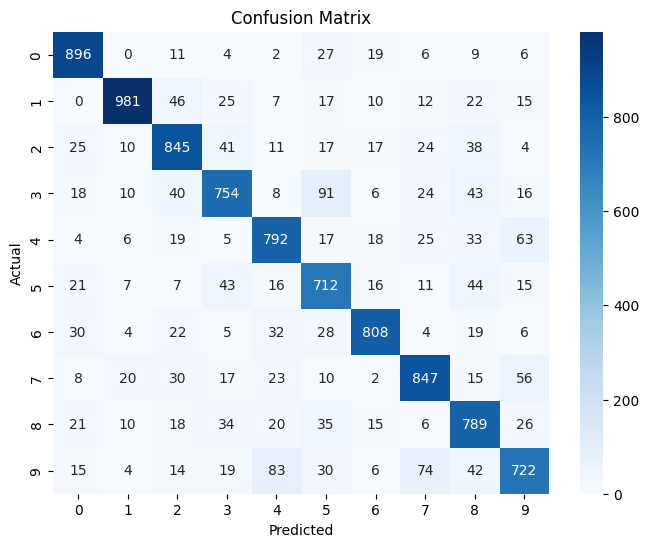

              precision    recall  f1-score   support

           0       0.86      0.91      0.89       980
           1       0.93      0.86      0.90      1135
           2       0.80      0.82      0.81      1032
           3       0.80      0.75      0.77      1010
           4       0.80      0.81      0.80       982
           5       0.72      0.80      0.76       892
           6       0.88      0.84      0.86       958
           7       0.82      0.82      0.82      1028
           8       0.75      0.81      0.78       974
           9       0.78      0.72      0.75      1009

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



In [111]:
evaluate_urbm_classifier(urbm_k10_loaded_01, test_loader, device)

Classification Accuracy: 83.53%


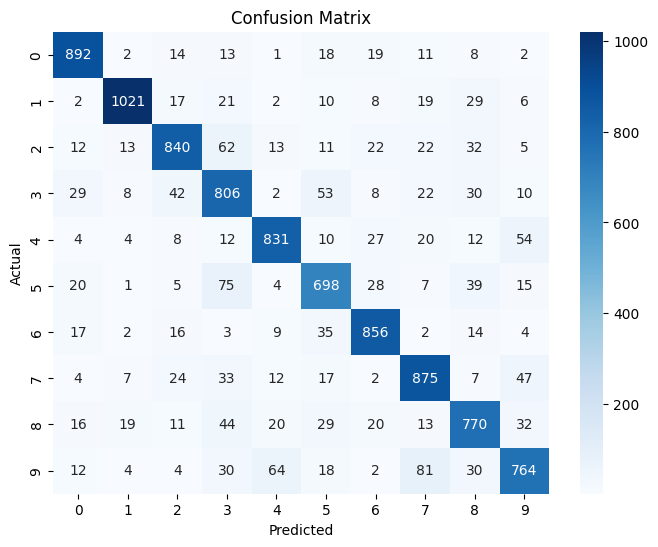

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       980
           1       0.94      0.90      0.92      1135
           2       0.86      0.81      0.83      1032
           3       0.73      0.80      0.76      1010
           4       0.87      0.85      0.86       982
           5       0.78      0.78      0.78       892
           6       0.86      0.89      0.88       958
           7       0.82      0.85      0.83      1028
           8       0.79      0.79      0.79       974
           9       0.81      0.76      0.78      1009

    accuracy                           0.84     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.84      0.84      0.84     10000



In [112]:
evaluate_urbm_classifier(urbm_k10_loaded_1, test_loader, device)